### Ruby Fluorescence Pressure Calculator

This is to help make the process of converting the ruby fluorescence data that the Craic reads out, easily done on the craic computer to cut out the need for exporting the data to your computer, plugging it in to Origin and getting the fit data that way. 

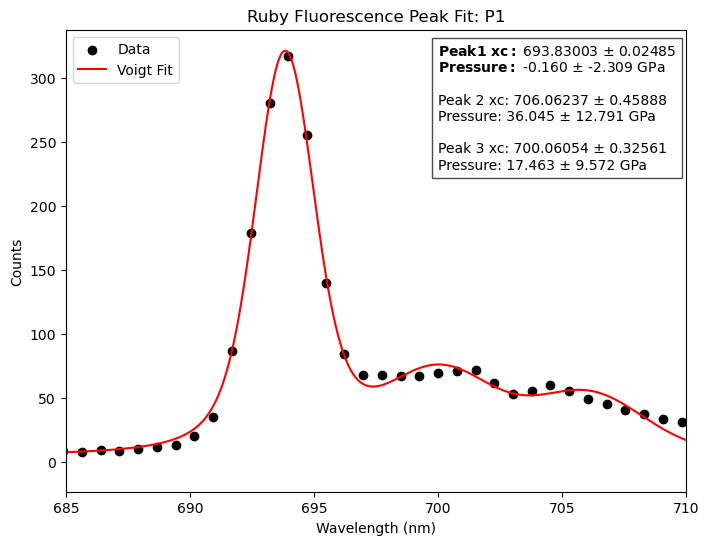

In [8]:
from typing import Tuple, Optional, List, Dict
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
from matplotlib.axes import Axes
from lmfit.models import VoigtModel, ConstantModel
from lmfit.parameter import Parameters
from scipy.signal import find_peaks
import os
import re

def read_two_column_txt(filepath: str) -> pd.DataFrame:
    return pd.read_csv(filepath, skiprows=3, delim_whitespace=True, header=None, names=["Wavelength (nm)", "Counts"])

def RF_peak_to_GPa_conversion(lambda_pk: float, lambda_ref: float = 693.88947) -> float:
    delta_lambda = lambda_pk - lambda_ref
    pressure = (1870 * (delta_lambda / lambda_ref)) * (1 + 5.63 * (delta_lambda / lambda_ref))
    return pressure

def RF_GPA_error(lambda_pk: float, lambda_pk_error: float, lambda_ref: float = 693.88947, lambda_ref_err: float = 0.07073) -> float:
    delta_lambda_err = lambda_ref_err + lambda_pk_error
    delta_lambda = lambda_pk - lambda_ref
    delta_lambda_over_lambda_ref_error = delta_lambda / lambda_ref * np.sqrt(
        (delta_lambda_err / delta_lambda)**2 + (lambda_ref_err / lambda_ref)**2)
    pressure_error = 1870 * delta_lambda_over_lambda_ref_error + 1870 * 5.63 * np.sqrt(2) * delta_lambda_over_lambda_ref_error
    return pressure_error

def detect_top_n_peaks(x: np.ndarray, y: np.ndarray, n_peaks: int = 3, distance: int = 2, prominence: float = 5.0) -> List[Dict]:
    peaks, properties = find_peaks(y, distance=distance, prominence=prominence)
    prominences = properties["prominences"]
    top_indices = np.argsort(prominences)[-n_peaks:][::-1]
    top_peaks = peaks[top_indices]

    guesses = []
    for peak in top_peaks:
        center = x[peak]
        amplitude = y[peak]
        guesses.append({
            'center': center,
            'amplitude': amplitude,
            'sigma': 0.6,
            'gamma': 0.6
        })
    return guesses

def fit_multi_voigt_lmfit(data: pd.DataFrame, xlim: Tuple[float, float], peak_guesses: List[Dict]) -> Optional[Tuple[np.ndarray, np.ndarray, Parameters]]:
    x = data["Wavelength (nm)"]
    y = data["Counts"]
    mask = (x >= xlim[0]) & (x <= xlim[1])
    x_fit_data = x[mask].values
    y_fit_data = y[mask].values

    if len(x_fit_data) == 0:
        return None

    model = ConstantModel(prefix='c_')
    params = model.make_params(c_c=40.0)

    for i, guess in enumerate(peak_guesses):
        prefix = f"v{i}_"
        voigt = VoigtModel(prefix=prefix)
        model += voigt
        params.update(voigt.make_params())
        params[f"{prefix}center"].set(value=guess["center"])
        params[f"{prefix}amplitude"].set(value=guess["amplitude"], min=0)
        params[f"{prefix}sigma"].set(value=guess["sigma"], min=0.1, max=2)
        params[f"{prefix}gamma"].set(value=guess["gamma"], min=0.1, max=2)

    result = model.fit(y_fit_data, params, x=x_fit_data)
    x_dense = np.linspace(xlim[0], xlim[1], 500)
    y_dense = model.eval(result.params, x=x_dense)

    return x_dense, y_dense, result.params

def plot_wavelength_counts(data: pd.DataFrame, xlim: Optional[Tuple[float, float]] = None, fit_voigt: bool = False, n_peaks: int = 3, filename: str = "") -> Tuple[Figure, Axes]:
    fig, ax = plt.subplots(figsize=(8, 6))
    x = data["Wavelength (nm)"]
    y = data["Counts"]
    ax.scatter(x, y, color='black', marker='o', label='Data')
    ax.set_xlabel("Wavelength (nm)")
    ax.set_ylabel("Counts")

    title_name = os.path.splitext(os.path.basename(filename))[0].replace('_RF', '').upper()
    ax.set_title(f"Ruby Fluorescence Peak Fit: {title_name}")

    if xlim:
        ax.set_xlim(xlim)

    if fit_voigt and xlim:
        mask = (x >= xlim[0]) & (x <= xlim[1])
        x_fit_data = x[mask].values
        y_fit_data = y[mask].values
        peak_guesses = detect_top_n_peaks(x_fit_data, y_fit_data, n_peaks=n_peaks, prominence=0.3)
        fit_result = fit_multi_voigt_lmfit(data, xlim, peak_guesses)
        if fit_result:
            x_fit, y_fit, params = fit_result
            ax.plot(x_fit, y_fit, color='red', label='Voigt Fit')
            ax.legend(loc="upper left")

            annotations = []
            for i in range(n_peaks):
                prefix = f"v{i}_"
                center = params[prefix + "center"].value
                center_err = params[prefix + "center"].stderr
                GPA = RF_peak_to_GPa_conversion(center)
                GPA_err = RF_GPA_error(center, center_err)

                if i == 0:
                    annotations.append(
                        rf"$\bf{{Peak {i+1}\ xc:}}$ {center:.5f} ± {center_err:.5f}" + "\n"
                        rf"$\bf{{Pressure:}}$ {GPA:.3f} ± {GPA_err:.3f} GPa"
                    )
                else:
                    annotations.append(
                        f"Peak {i+1} xc: {center:.5f} ± {center_err:.5f}\n"
                        f"Pressure: {GPA:.3f} ± {GPA_err:.3f} GPa"
                    )

            ax.text(0.60, 0.97, "\n\n".join(annotations), transform=ax.transAxes,
                    fontsize=10, verticalalignment='top',
                    bbox=dict(facecolor='white', alpha=0.7))

    return fig, ax

if __name__ == "__main__":
    # make sure to enter a txt FILE in belw not a folder or it wont work
    df = pd.read_csv("p1.1_RF.txt", skiprows=3, delim_whitespace=True, header=None, names=["Wavelength (nm)", "Counts"])
    fig, ax = plot_wavelength_counts(df, xlim=(685, 710), fit_voigt=True, n_peaks=3, filename="p1_RF.txt")
    plt.show()


# Extract directory and filename (without extension)
# save_dir = os.path.dirname(filepath)
# filename_without_ext = os.path.splitext(os.path.basename(filepath))[0]

# # Set PNG save path
# save_path = os.path.join(save_dir, f"{filename_without_ext}.png")

# # Save the figure
# fig.savefig(save_path, dpi=600)
# print(f"Saved figure to: {save_path}")